In [34]:
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
import datetime as dt
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
import os
from shutil import copy
import seaborn as sns
import scipy.stats as stats
import datetime
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pickle
import imageio
from itertools import compress

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams.update({'figure.max_open_warning': 0})

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
          'legend.title_fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
#‘xx-small’, ‘x-small’, ‘small’, ‘medium’, ‘large’, ‘x-large’, ‘xx-large’
pylab.rcParams.update(params)
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
# from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from statsmodels.tsa.api import VAR

from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn import tree

import re

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.stats import mannwhitneyu
from scipy.stats import spearmanr

In [76]:
# df=pd.read_csv('data\\significant_factors_temperature.csv')
# df['fw_cycle_length'].isna().sum()

# df = pd.read_csv(root_path+'factors_gender.csv')
# df = pd.read_csv(root_path+'factors_gender_dom. threshold=0.9.csv')
# df = pd.read_csv(root_path+'factors_gender_dom.threshold=0.95.csv')
# df=pd.concat([df, pd.get_dummies(df['dominating_gender'])],axis=1)

root_path = 'data\\'

df=pd.read_csv(root_path+'factors_mortality_rate_all_reasons.csv')
targets = pd.read_csv(root_path+'targets.csv')


key_columns = ['locus_id', 'fish_group_id', 'transfer_year']
selected_targets = ['total_mortality_perc_90']
selected_factors = ['mortality_rate-around_vaccination-sum_Eliminación Opérculo','mortality_rate-whole_period-sum_Eliminación Plateado']

df = df[key_columns+selected_factors].merge(targets[key_columns+selected_targets], how='right', on = key_columns)

In [22]:
factor = 'mortality_rate-whole_period-sum_Eliminación Plateado'
target = 'total_mortality_perc_90'

In [23]:
# plot_slide_chart_no_bins(factor=factor,
#                  target=target,
#                  finding_name='Gender',
#                  low_q=.001,
#                  high_q=.999,
#                  step=.25,
#                  format_chart='perc',
#                  arr_for_chart=arr_for_test.merge(df[key_columns+['weight_M','weight_H']],on=key_columns,how='left'),
#                  main_factor = 'weight_M',
#                  ylabel='mortality',
#                  xlabel='gender')
def plot_slide_chart_no_bins(factor, finding_name, low_q, high_q, step, format_chart,target,arr_for_chart,main_factor,ylabel=target,xlabel=factor):
    sns.set_style("whitegrid")
    
    font_size = 18
    bins_tuple = tuple(i * step for i in range(
        int(arr_for_chart[factor].quantile(low_q) / step), int(arr_for_chart[factor].quantile(high_q) / step) + 1)
    )
    
    arr_for_chart[factor+'_binned'] = pd.cut(arr_for_chart[factor], bins=bins_tuple)

    x_axis_factor = factor
    y_axis_factor = target
    
    f, axs = plt.subplots(1, 1, figsize=(14, 7))
    
    # Create boxplot
    box_plot = sns.boxplot(data=arr_for_chart, x=x_axis_factor, y=y_axis_factor, width=.2)

    # Calculate medians
    medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
    medians2 = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()
    
#     Plot values in medians on the chart
    vertical_offset = arr_for_chart[y_axis_factor].median() * 0.00 # offset from median for display
    for xtick in box_plot.get_xticks():
        box_plot.text(xtick + 0.18,medians.iloc[xtick] + vertical_offset,f'{100 * target_means.iloc[xtick]:.2f}%',
                      horizontalalignment='center',size=font_size,color='black',weight='semibold')

    # Update x-axis labels
    xtick_labels = [tick.get_text() for tick in axs.get_xticklabels()]
    counts = arr_for_chart[x_axis_factor].value_counts().sort_index()
    
#     updated_labels = []
#     for i, v in enumerate(xtick_labels):
#         bin_range1 = v.split(", ")[0][1:]
#         bin_range2 = v.split(", ")[1][:-1]
#         if format_chart == 'perc':
#             updated_label = "{:.0%}".format(float(bin_range1)) + ' to ' + "{:.0%}".format(float(bin_range2))
#         elif format_chart == 'one_dec':
#             updated_label = "{:.1}".format(float(bin_range1)) + ' to ' + "{:.1}".format(float(bin_range2))
#         elif format_chart == 'two_dec':
#             updated_label = "{:.2}".format(float(bin_range1)) + ' to ' + "{:.2}".format(float(bin_range2))
#         updated_labels.append(f"{updated_label} ")
#     axs.set_xticklabels(updated_labels)
#     axs.set_xticklabels([f'H ({counts[0]})',f'M ({counts[1]})'])

    # Add black dots with average values
    for i, xtick in enumerate(box_plot.get_xticks()):
        bin_data = arr_for_chart[arr_for_chart[x_axis_factor] == xtick_labels[i]]
        avg_value = medians.iloc[i]
        axs.plot(xtick, avg_value, marker='o', markersize=8, color='black')
    
    # Create table
    format_float = np.vectorize(lambda x: "{:.4f}".format(x))
    result_array = np.vstack((format_float(100*medians), format_float(medians2), counts.values.astype(int)))

    # For mortality target - Set the y-axis tick format as percentage
    if 'mortality' in target: box_plot.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals = 0))
    
    box_plot.set_ylabel(ylabel)
    box_plot.set_xlabel(xlabel)
    
    # Set the fontsize for all elements in the plot
    for item in ([box_plot.xaxis.label, box_plot.yaxis.label] +
                 box_plot.get_xticklabels() + box_plot.get_yticklabels()):
        item.set_fontsize(font_size)

    # Save the figure
    plt.savefig(f'Visualisation\slides\{finding_name}_Boxplot_{ylabel}_vs_{xlabel}_slide.png')

    return result_array

In [24]:
# plot_slide_chart(factor=factor,
#                  target=target,
#                  finding_name='Gender',
#                  low_q=.001,
#                  high_q=.999,
#                  step=.25,
#                  format_chart='perc',
#                  arr_for_chart=arr_for_test.merge(df[key_columns+['weight_M','weight_H']],on=key_columns,how='left'),
#                  main_factor = 'weight_M',
#                  ylabel='mortality',
#                  xlabel='gender')
def plot_slide_chart(factor, finding_name, low_q, high_q, step, format_chart,target,arr_for_chart,main_factor,ylabel=target,xlabel=factor):
    sns.set_style("whitegrid")

    bins_tuple = tuple(i * step for i in range(
        int(arr_for_chart[factor].quantile(low_q) / step), int(arr_for_chart[factor].quantile(high_q) / step) + 1)
    )
    
    arr_for_chart[factor+'_binned'] = pd.cut(arr_for_chart[factor], bins=bins_tuple)

    x_axis_factor = factor+'_binned'
    y_axis_factor = target
    
    f, axs = plt.subplots(1, 1, figsize=(16, 8))
    
    # Create boxplot
    box_plot = sns.boxplot(data=arr_for_chart, x=x_axis_factor, y=y_axis_factor, width=.2)

    # Calculate medians
    medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
    medians2 = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()
    
    # Plot values in medians on the chart
#     vertical_offset = arr_for_chart[y_axis_factor].median() * 0.00 # offset from median for display
#     for xtick in box_plot.get_xticks():
#         box_plot.text(xtick + 0.15,medians.iloc[xtick] + vertical_offset,f'{100 * target_means.iloc[xtick]:.2f}%',
#                       horizontalalignment='center',size='xx-large',color='black',weight='semibold')

    # Update x-axis labels
    xtick_labels = [tick.get_text() for tick in axs.get_xticklabels()]
    counts = arr_for_chart[x_axis_factor].value_counts().sort_index()
    
    updated_labels = []
    for i, v in enumerate(xtick_labels):
        bin_range1 = v.split(", ")[0][1:]
        bin_range2 = v.split(", ")[1][:-1]
        if format_chart == 'perc':
            updated_label = "{:.0%}".format(float(bin_range1)) + ' to ' + "{:.0%}".format(float(bin_range2))
        elif format_chart == 'one_dec':
            updated_label = "{:.1}".format(float(bin_range1)) + ' to ' + "{:.1}".format(float(bin_range2))
        elif format_chart == 'two_dec':
            updated_label = "{:.2}".format(float(bin_range1)) + ' to ' + "{:.2}".format(float(bin_range2))
        updated_labels.append(f"{updated_label} ")
    axs.set_xticklabels(updated_labels)

    # Add black dots with average values
    for i, xtick in enumerate(box_plot.get_xticks()):
        bin_data = arr_for_chart[arr_for_chart[x_axis_factor] == xtick_labels[i]]
        avg_value = medians.iloc[i]
        axs.plot(xtick, avg_value, marker='o', markersize=8, color='black')
    
    # Create table
    format_float = np.vectorize(lambda x: "{:.4f}".format(x))
    result_array = np.vstack((format_float(100*medians), format_float(medians2), counts.values.astype(int)))

    # For mortality target - Set the y-axis tick format as percentage
    if 'mortality' in target: box_plot.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals = 0))
    
    box_plot.set_ylabel(ylabel)
    box_plot.set_xlabel(xlabel)
    
    # Set the fontsize for all elements in the plot
    for item in ([box_plot.xaxis.label, box_plot.yaxis.label] +
                 box_plot.get_xticklabels() + box_plot.get_yticklabels()):
        item.set_fontsize(font_size)

    # Save the figure
    plt.savefig(f'Visualisation\slides\{finding_name}_Boxplot_{ylabel}_vs_{xlabel}_slide.png')

    return result_array

In [26]:
arr_for_test.columns

Index(['locus_id', 'fish_group_id', 'transfer_year',
       'mortality_rate-around_vaccination-sum_Eliminación Opérculo',
       'mortality_rate-whole_period-sum_Eliminación Plateado',
       'total_mortality_perc_90'],
      dtype='object')

In [44]:
selected_factors

['mortality_rate-around_vaccination-sum_Eliminación Opérculo',
 'mortality_rate-whole_period-sum_Eliminación Plateado']

In [27]:
target = 'total_mortality_perc_90'
# target = 'TGC_SW'
factor = 'mortality_rate-whole_period-sum_Eliminación Plateado'

arr_for_test = df[df.transfer_year.isin([2021,2022])]

arr_for_test['group'] = np.where(arr_for_test[factor]>0.01, 1, 0)
filtered_df=arr_for_test[['group', 'transfer_year', target]].dropna()

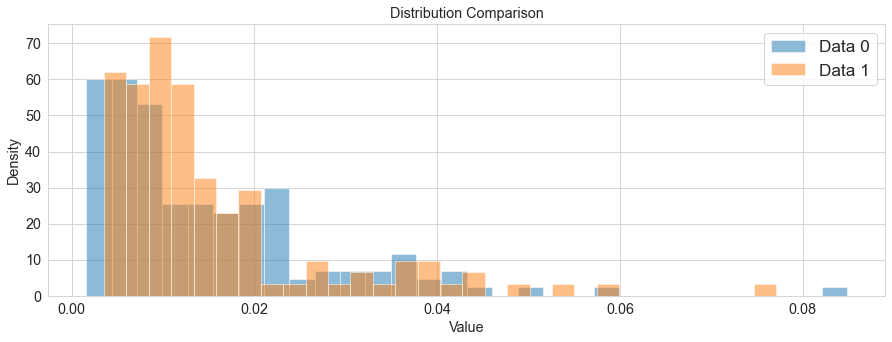

In [29]:
sns.set_style('whitegrid')

data0 = filtered_df[filtered_df['group'] == 0][target]
data1 = filtered_df[filtered_df['group'] == 1][target]
plt.hist(data0, bins=30, alpha=0.5, label='Data 0', density=True)
plt.hist(data1, bins=30, alpha=0.5, label='Data 1', density=True)

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution Comparison')
plt.legend()

plt.show()

<AxesSubplot:xlabel='total_mortality_perc_90', ylabel='mortality_rate-whole_period-sum_Eliminación Plateado'>

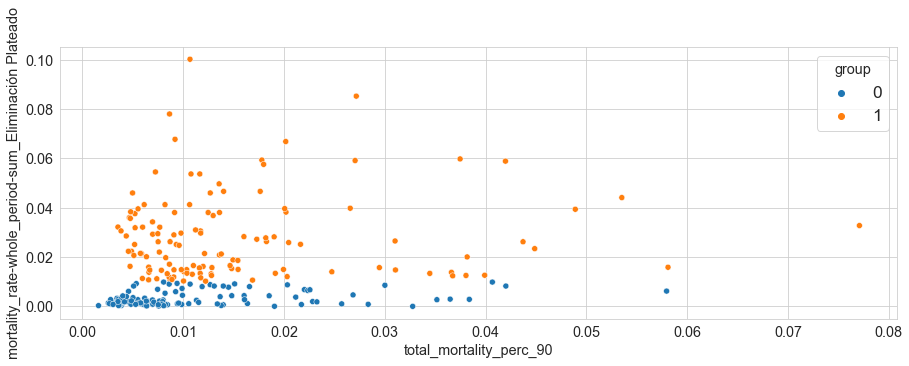

In [30]:
sns.scatterplot(data=arr_for_test, x=target, y=factor, hue='group')

In [ ]:
# df_smolt_data_filtered=df_smolt_data[df_smolt_data['rolling_tempr_sum']<6000]

# # Scatter plot
# scatter_plot = sns.scatterplot(data=df_smolt_data_filtered, x='total_mortality_perc_90', y=xfactor, hue='group')

# # Calculate the median of the 'TGC' column
# median_value = df_smolt_data_filtered['TGC'].median()

# # Add horizontal dashed line
# scatter_plot.axhline(median_value, linestyle='--', color='green')

# # Add text label
# scatter_plot.text(df_smolt_data_filtered['total_mortality_perc_90'].max(), median_value, f"median={median_value:.2f}", color='green',fontsize=18, ha='right', va='top')

# # Display the plot
# # plt.show()
# # plt.savefig('TGC_vs_mortality_hypo1.png')

In [31]:
mean_values = filtered_df.groupby('group')[target].mean()
median_values = filtered_df.groupby('group')[target].median()
# mode_values = df.groupby('group')[target].agg(pd.Series.mode)
min_values = filtered_df.groupby('group')[target].min()
max_values = filtered_df.groupby('group')[target].max()
# Print the results
print("Mean values:")
print(mean_values)
print("\nMedian values:")
print(median_values)
# print("\nMode values:")
# print(mode_values)
print("\nMinimum values:")
print(min_values)
print("\nMaximum values:")
print(max_values)

Mean values:
group
0    0.014936
1    0.015541
Name: total_mortality_perc_90, dtype: float64

Median values:
group
0    0.010623
1    0.011614
Name: total_mortality_perc_90, dtype: float64

Minimum values:
group
0    0.001601
1    0.003529
Name: total_mortality_perc_90, dtype: float64

Maximum values:
group
0    0.084886
1    0.077095
Name: total_mortality_perc_90, dtype: float64


In [35]:
num_samples=10000
sample_size=20
p_values=[]
u_stats=[]
for i in range(num_samples):
    sample0 = np.random.choice(data0, size=sample_size, replace=True)
    sample1 = np.random.choice(data1, size=sample_size, replace=True)
#     statistic, p_value = mannwhitneyu(sample0, sample1, alternative='two-sided')
    statistic, p_value = mannwhitneyu(sample0, sample1, alternative='less')
#     statistic, p_value = mannwhitneyu(sample1, sample0, alternative='less')
#     statistic, p_value = mannwhitneyu(sample0, sample1, alternative='greater')
#     statistic, p_value = mannwhitneyu(sample1, sample0, alternative='greater')


    p_values.append(p_value)
    u_stats.append(statistic)
#     print("Mann-Whitney U statistic: ", statistic)
#     print("P-Value: ", p_value)

#critical value for U-stats with sample size(20,20)=138
passed_count=0
for i in range (0,len(u_stats)):    
    if p_values[i]<=0.05 and u_stats[i]<=138:
        passed_count=passed_count+1
print("Number of tests passed=",passed_count,"/",num_samples,"tests runned")
print(f'{100*passed_count/num_samples}%')

Number of tests passed= 1039 / 10000 tests runned
10.39%


In [41]:
# Assuming df is your DataFrame
arr_for_test_nona = arr_for_test.dropna()
correlation, p_value = spearmanr(arr_for_test_nona[factor], arr_for_test_nona[target])

print(f"Spearman Correlation Coefficient between {factor} and {target}: {correlation}")
# print(f"P-value: {p_value}")
correlation = arr_for_test[factor].corr(arr_for_test[target])
print(f"Pearson correlation between {factor} and {target}:", correlation)

Spearman Correlation Coefficient between mortality_rate-whole_period-sum_Eliminación Plateado and total_mortality_perc_90: 0.2933360016601163
Pearson correlation between mortality_rate-whole_period-sum_Eliminación Plateado and total_mortality_perc_90: 0.1790259167328022


In [143]:
target = 'total_mortality_perc_90'
# target = 'TGC_SW'
factor = 'mortality_rate-around_vaccination-sum_Eliminación Opérculo'

# arr_for_test = df[df.transfer_year.isin([2020,2021,2022])]
arr_for_test = df[df.transfer_year.isin([2022])]


arr_for_test['group'] = np.where(np.isnan(arr_for_test[factor]), np.nan,
                                 np.where(arr_for_test[factor] > 0.005, 1, 0))
filtered_df=arr_for_test[['group', 'transfer_year', target]].dropna()

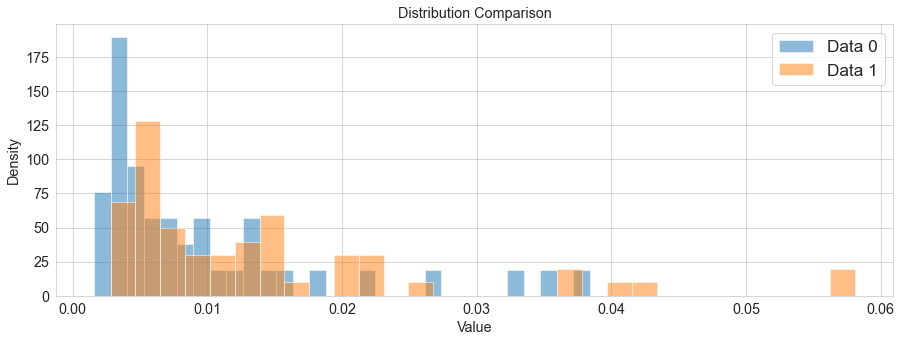

43 55


In [144]:
sns.set_style('whitegrid')

data0 = filtered_df[filtered_df['group'] == 0][target]
data1 = filtered_df[filtered_df['group'] == 1][target]
plt.hist(data0, bins=30, alpha=0.5, label='Data 0', density=True)
plt.hist(data1, bins=30, alpha=0.5, label='Data 1', density=True)

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution Comparison')
plt.legend()

plt.show()
print(len(data0),len(data1))

<AxesSubplot:xlabel='total_mortality_perc_90', ylabel='mortality_rate-around_vaccination-sum_Eliminación Opérculo'>

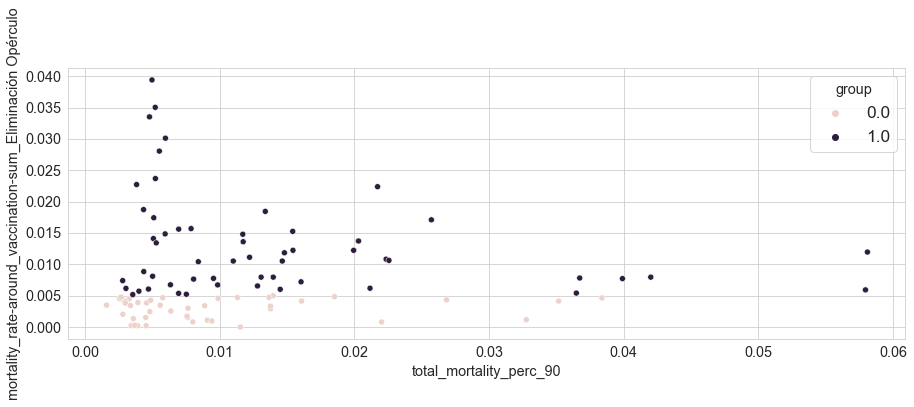

In [145]:
sns.scatterplot(data=arr_for_test, x=target, y=factor, hue='group')

In [146]:
mean_values = filtered_df.groupby('group')[target].mean()
median_values = filtered_df.groupby('group')[target].median()
# mode_values = df.groupby('group')[target].agg(pd.Series.mode)
min_values = filtered_df.groupby('group')[target].min()
max_values = filtered_df.groupby('group')[target].max()
# Print the results
print("Mean values:")
print(mean_values)
print("\nMedian values:")
print(median_values)
# print("\nMode values:")
# print(mode_values)
print("\nMinimum values:")
print(min_values)
print("\nMaximum values:")
print(max_values)

Mean values:
group
0.0    0.009788
1.0    0.014115
Name: total_mortality_perc_90, dtype: float64

Median values:
group
0.0    0.006377
1.0    0.009855
Name: total_mortality_perc_90, dtype: float64

Minimum values:
group
0.0    0.001601
1.0    0.002803
Name: total_mortality_perc_90, dtype: float64

Maximum values:
group
0.0    0.038390
1.0    0.058104
Name: total_mortality_perc_90, dtype: float64


In [147]:
num_samples=10000
sample_size=20
p_values=[]
u_stats=[]
for i in range(num_samples):
    sample0 = np.random.choice(data0, size=sample_size, replace=True)
    sample1 = np.random.choice(data1, size=sample_size, replace=True)
#     statistic, p_value = mannwhitneyu(sample0, sample1, alternative='two-sided')
    statistic, p_value = mannwhitneyu(sample0, sample1, alternative='less')
#     statistic, p_value = mannwhitneyu(sample1, sample0, alternative='less')
#     statistic, p_value = mannwhitneyu(sample0, sample1, alternative='greater')
#     statistic, p_value = mannwhitneyu(sample1, sample0, alternative='greater')


    p_values.append(p_value)
    u_stats.append(statistic)
#     print("Mann-Whitney U statistic: ", statistic)
#     print("P-Value: ", p_value)

#critical value for U-stats with sample size(20,20)=138
passed_count=0
for i in range (0,len(u_stats)):    
    if p_values[i]<=0.05 and u_stats[i]<=138:
        passed_count=passed_count+1
print("Number of tests passed=",passed_count,"/",num_samples,"tests runned")
print(f'{100*passed_count/num_samples}%')

Number of tests passed= 4592 / 10000 tests runned
45.92%


In [153]:
# Assuming df is your DataFrame
arr_for_test_nona = arr_for_test.dropna()
correlation, p_value = spearmanr(arr_for_test_nona[factor], arr_for_test_nona[target])

print(f"Spearman Correlation Coefficient between {factor} and {target}: {correlation}")
# print(f"P-value: {p_value}")
correlation = arr_for_test[factor].corr(arr_for_test[target])
print(f"Pearson correlation between {factor} and {target}:", correlation)

Spearman Correlation Coefficient between mortality_rate-around_vaccination-sum_Eliminación Opérculo and total_mortality_perc_90: 0.2012356069378471
Pearson correlation between mortality_rate-around_vaccination-sum_Eliminación Opérculo and total_mortality_perc_90: -0.03455855161295788


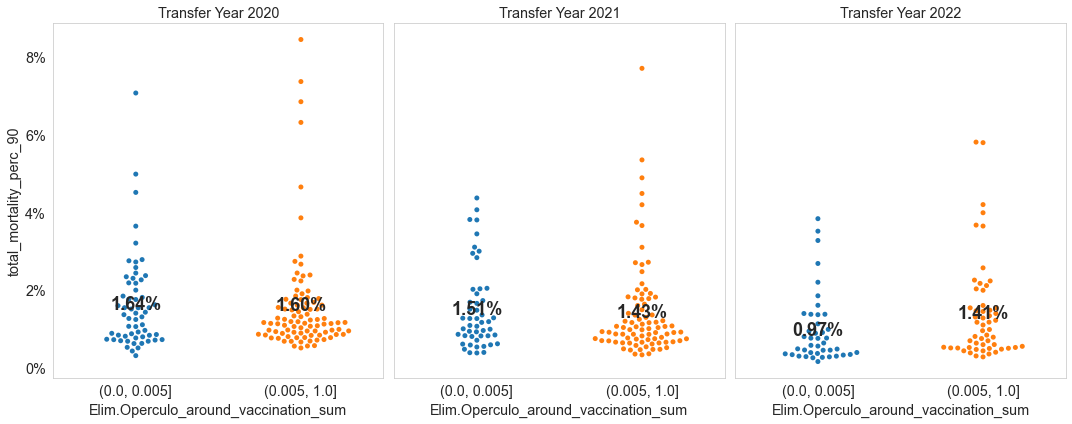

In [167]:
font_size = 18
arr_for_chart = df[df.transfer_year.between(2020,2022)]
transfer_years = sorted(arr_for_chart['transfer_year'].unique())
# transfer_years.remove(2023)

# factor = 'group'
# target = 'mortality'

bins = [0,0.005,1]
# Create subplots for each transfer year
fig, axs = plt.subplots(nrows=1, ncols=len(transfer_years), figsize=(15, 6), sharey=True)

# Iterate over the transfer years and create swarmplots
for i, year in enumerate(transfer_years):
    ax = axs[i]  # Select the subplot for the current year
#     ax = axs  # Select the subplot for the current year
    
    # Filter the data for the current transfer year
    data_year = arr_for_chart[arr_for_chart['transfer_year'] == year]#.sort_values(by=factor,ascending=False)
    data_year[factor+'_binned'] = pd.cut(data_year[factor], bins=bins)
    x_axis_factor = factor + '_binned'
    # Create the swarmplot for the current year
#     sns.swarmplot(data=data_year, x='main_producer', y='mortality', ax=ax)
    sns.swarmplot(data=data_year, x=x_axis_factor, y=target, ax=ax)
    
    # Get the x-axis labels
    x_labels = [tick.get_text() for tick in ax.get_xticklabels()]

    # Calculate the average mortality for each category
#     mortality_means = data_year.groupby('main_producer')['mortality'].mean()
    mortality_means = data_year.groupby(x_axis_factor)[target].mean()

    vertical_offset = data_year[target].median() * 0.00 # offset from median for display
    # Add the average values to the plot
    for j, (label, value) in enumerate(mortality_means.items()):
        ax.text(j, mortality_means.iloc[j], f'{100 * mortality_means.iloc[j]:.2f}%', ha='center', va='center', fontsize=font_size, fontweight='bold')

    # Set the y-axis tick format as percentage
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals = 0))
    
    ax.grid(axis='y')

    # Set labels and title for the subplot
    ax.set_xlabel('Elim.Operculo_around_vaccination_sum')
    ax.set_title(f'Transfer Year {year}')
    
    # Remove y-axis label for all but the first subplot
    if i > 0:
        ax.set_ylabel('')
        
# Set a common y-axis label
# axs[0].set_ylabel('Mortality')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.savefig(f'Visualisation\swarmplot_{target}_vs_{factor}.png')
# plt.show()

In [164]:
df.groupby('transfer_year')[factor].apply(lambda x:(x>0).sum())

transfer_year
2017      0
2018      0
2019     32
2020    150
2021    134
2022     97
2023     35
Name: mortality_rate-around_vaccination-sum_Eliminación Opérculo, dtype: int64

In [97]:
mortality_means

mortality_rate-around_vaccination-sum_Eliminación Opérculo
0.000000    0.020243
0.000004    0.017578
0.000008    0.019992
0.000052    0.032098
0.000119    0.070746
              ...   
0.037350    0.016132
0.037969    0.019776
0.038970    0.010631
0.039525    0.023661
0.050209    0.010825
Name: total_mortality_perc_90, Length: 146, dtype: float64

In [74]:
arr_for_chart

,locus_id,fish_group_id,transfer_year,mortality_rate-around_vaccination-sum_Eliminación Opérculo,mortality_rate-whole_period-sum_Eliminación Plateado,total_mortality_perc_90,group
8,3046046,4150,2021,NaN,NaN,0.018459,0
12,3046064,5736,2021,0.013832,0.026308,0.018263,1
16,3046103,6045,2022,NaN,NaN,0.016196,0
22,3046142,6045,2022,NaN,NaN,0.025086,0
26,3046150,5737,2021,0.002543,0.008048,0.011880,0
...,...,...,...,...,...,...,...
1257,7183889,6071,2022,0.006549,0.012568,0.012813,1
1258,7183890,6072,2022,0.011836,0.015369,0.014813,1
1259,7183891,6072,2022,0.010520,0.016580,0.014654,1
1260,7183892,6069,2022,0.010622,0.006767,0.022576,1


array([['1.6627', '1.2213'],
       ['0.0000', '0.9741'],
       ['185', '162']], dtype='<U11')

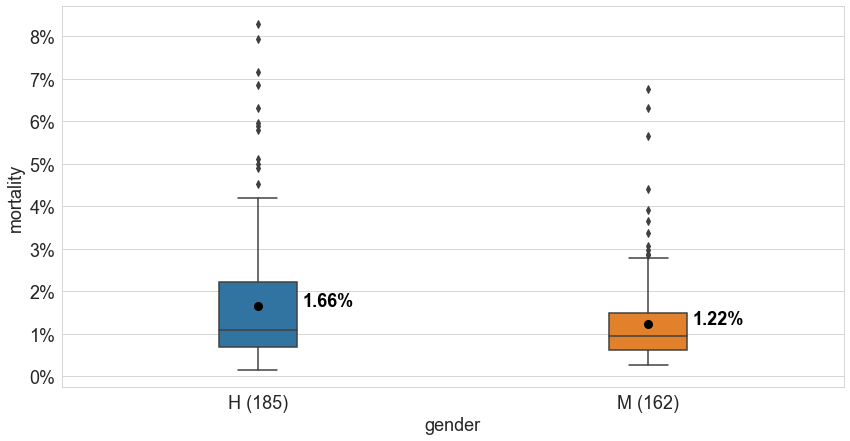

In [391]:
plot_slide_chart_no_bins(factor=factor,
                 target=target,
                 finding_name='Gender',
                 low_q=.001,
                 high_q=.999,
                 step=.25,
                 format_chart='perc',
                 arr_for_chart=arr_for_test.merge(df[key_columns+['weight_M','weight_H']],on=key_columns,how='left'),
                 main_factor = 'weight_M',
                 ylabel='mortality',
                 xlabel='gender')

array([['299.3343', '293.1071'],
       ['0.0000', '0.9741'],
       ['185', '162']], dtype='<U11')

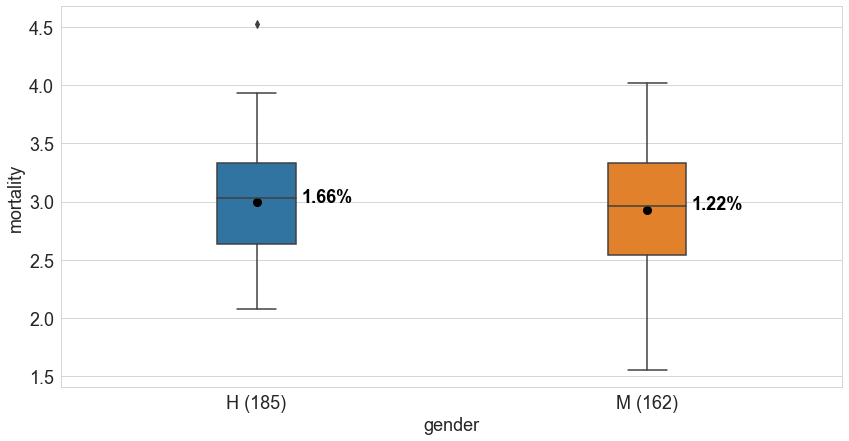

In [392]:
plot_slide_chart_no_bins(factor=factor,
                 target='TGC_SW',
                 finding_name='Gender',
                 low_q=.001,
                 high_q=.999,
                 step=.25,
                 format_chart='perc',
                 arr_for_chart=arr_for_test.merge(df[key_columns+['weight_M','weight_H']],on=key_columns,how='left'),
                 main_factor = 'weight_M',
                 ylabel='mortality',
                 xlabel='gender')

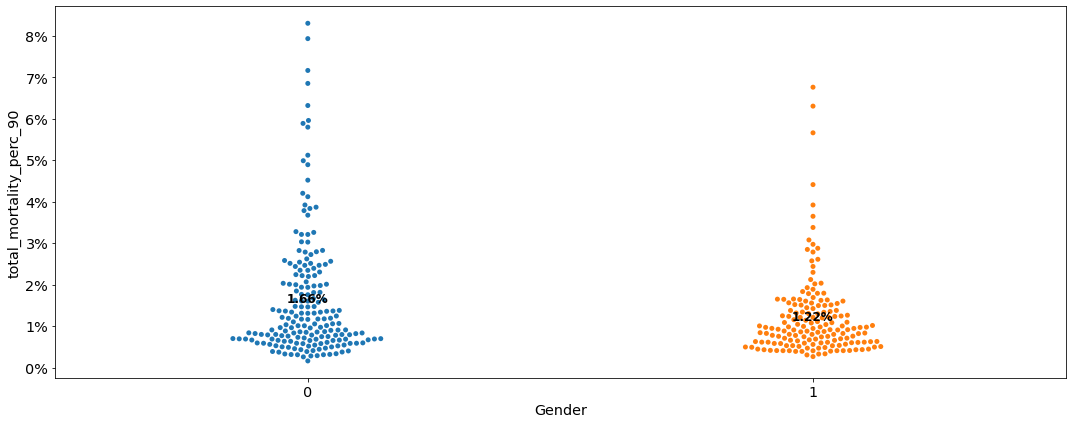

In [230]:
font_size = 12
arr_for_chart = filtered_df.copy()

transfer_years = sorted(arr_for_chart['transfer_year'].unique())
# transfer_years.remove(2023)

factor = 'group'

# Create subplots for each transfer year
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))

ax = axs
data_year = arr_for_chart

# Create the swarmplot for the current year
#     sns.swarmplot(data=data_year, x='main_producer', y='mortality', ax=ax)
sns.swarmplot(data=data_year, x=factor, y=target, ax=ax)

# Get the x-axis labels
x_labels = [tick.get_text() for tick in ax.get_xticklabels()]

# Calculate the average mortality for each category
#     mortality_means = data_year.groupby('main_producer')['mortality'].mean()
target_means = data_year.groupby(factor)[target].mean()

# Add the average values to the plot
for j, (label, value) in enumerate(mortality_means.items()):
#         print(x_labels[j])
    ax.text(j, target_means.loc[int(x_labels[j])], f'{100 * target_means.loc[int(x_labels[j])]:.2f}%', ha='center', va='center', fontsize=font_size, fontweight='bold')
#     ax.text(j, target_means.loc[int(x_labels[j])], f'{target_means.loc[int(x_labels[j])]:.2f}', ha='center', va='center', fontsize=font_size, fontweight='bold')


# Set the y-axis tick format as percentage
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals = 0))


# Set labels and title for the subplot
ax.set_xlabel('Gender')
# ax.set_title(f'Transfer Year {year}')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
# plt.savefig('Visualisation\\main_producer_mortality_splitted_by_transfer_year_ElimxRunt.png')
# plt.show()

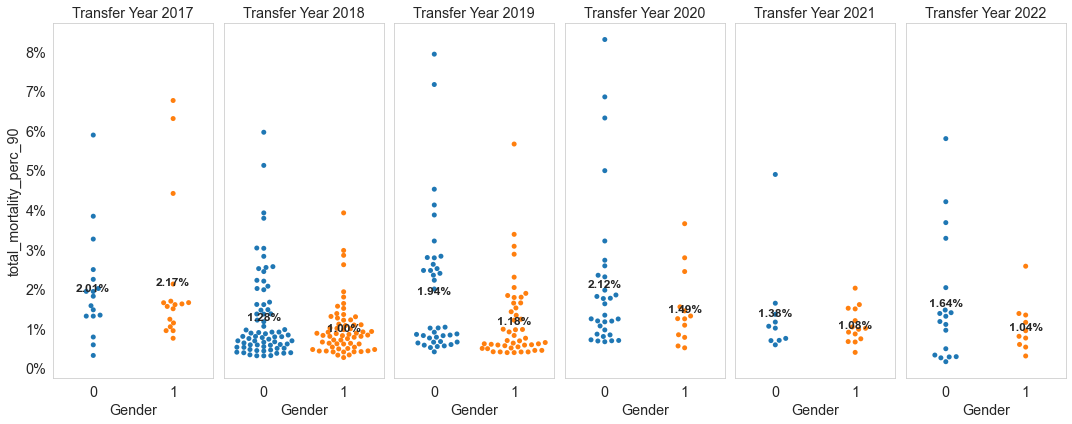

In [354]:
font_size = 12
arr_for_chart = filtered_df.copy()

transfer_years = sorted(arr_for_chart['transfer_year'].unique())
# transfer_years.remove(2023)

factor = 'group'
# target = 'mortality'

# Create subplots for each transfer year
fig, axs = plt.subplots(nrows=1, ncols=len(transfer_years), figsize=(15, 6), sharey=True)

# Iterate over the transfer years and create swarmplots
for i, year in enumerate(transfer_years):
    ax = axs[i]  # Select the subplot for the current year
#     ax = axs  # Select the subplot for the current year
    
    # Filter the data for the current transfer year
    data_year = arr_for_chart[arr_for_chart['transfer_year'] == year].sort_values(by=factor,ascending=False)
    
    # Create the swarmplot for the current year
#     sns.swarmplot(data=data_year, x='main_producer', y='mortality', ax=ax)
    sns.swarmplot(data=data_year, x=factor, y=target, ax=ax)
    
    # Get the x-axis labels
    x_labels = [tick.get_text() for tick in ax.get_xticklabels()]

    # Calculate the average mortality for each category
#     mortality_means = data_year.groupby('main_producer')['mortality'].mean()
    mortality_means = data_year.groupby(factor)[target].mean()


    # Add the average values to the plot
    for j, (label, value) in enumerate(mortality_means.items()):
#         print(x_labels[j])
        ax.text(j, mortality_means.loc[int(x_labels[j])], f'{100 * mortality_means.loc[int(x_labels[j])]:.2f}%', ha='center', va='center', fontsize=font_size, fontweight='bold')
    
    # Set the y-axis tick format as percentage
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals = 0))
    
    ax.grid(axis='y')

    # Set labels and title for the subplot
    ax.set_xlabel('Gender')
    ax.set_title(f'Transfer Year {year}')
    
    # Remove y-axis label for all but the first subplot
    if i > 0:
        ax.set_ylabel('')
        
# Set a common y-axis label
# axs[0].set_ylabel('Mortality')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
# plt.savefig('Visualisation\\main_producer_mortality_splitted_by_transfer_year_ElimxRunt.png')
# plt.show()